# This notebooks is about data generation of observed congestions in calibrated env

In this notebook bis for data generation, when thermal limits already exist for your environment, you can afterwards generate a summary dataframe on observed congestions. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#This-notebooks-is-about-data-generation-of-observed-congestions-in-calibrated-env" data-toc-modified-id="This-notebooks-is-about-data-generation-of-observed-congestions-in-calibrated-env-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>This notebooks is about data generation of observed congestions in calibrated env</a></span><ul class="toc-item"><li><span><a href="#Config-parameters-for-data-generation" data-toc-modified-id="Config-parameters-for-data-generation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Config parameters for data generation</a></span></li><li><span><a href="#Load-the-environment" data-toc-modified-id="Load-the-environment-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load the environment</a></span></li><li><span><a href="#Load-the-generated-data" data-toc-modified-id="Load-the-generated-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the generated data</a></span><ul class="toc-item"><li><span><a href="#Build-specific-dataframe-on-overloads-based-on-flow-results" data-toc-modified-id="Build-specific-dataframe-on-overloads-based-on-flow-results-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Build specific dataframe on overloads based on flow results</a></span><ul class="toc-item"><li><span><a href="#ligther-df_analysis-and-best_agent-overload-info" data-toc-modified-id="ligther-df_analysis-and-best_agent-overload-info-1.3.1.1"><span class="toc-item-num">1.3.1.1&nbsp;&nbsp;</span>ligther df_analysis and best_agent overload info</a></span></li><li><span><a href="#check-that-scenarios-are-continuous-in-the-indices-of-the-resultating-dataframe.-Otherwise-reorder" data-toc-modified-id="check-that-scenarios-are-continuous-in-the-indices-of-the-resultating-dataframe.-Otherwise-reorder-1.3.1.2"><span class="toc-item-num">1.3.1.2&nbsp;&nbsp;</span>check that scenarios are continuous in the indices of the resultating dataframe. Otherwise reorder</a></span></li></ul></li><li><span><a href="#Build-specific-dataframe-on-overloads-based-on-flow-results-with-best-agent" data-toc-modified-id="Build-specific-dataframe-on-overloads-based-on-flow-results-with-best-agent-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Build specific dataframe on overloads based on flow results with best agent</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import os
import re
import numpy as np
import pandas as pd
import fastparquet
import grid2op
import cufflinks as cf
from grid2op.PlotGrid import PlotMatplot
import pyarrow #necessary for saving dataframe in feather format
from grid2op.Parameters import Parameters
from grid2op.Chronics import Multifolder, GridStateFromFileWithForecasts
from lightsim2grid import LightSimBackend
from tqdm.notebook import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from grid2op.PlotGrid import PlotMatplot
from grid2op.PlotGrid import NUKE_COLOR, THERMAL_COLOR, HYDRO_COLOR, SOLAR_COLOR, WIND_COLOR
import matplotlib.pyplot as matplt
import seaborn as sns
%matplotlib inline

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import ipywidgets as widgets
from ipywidgets import Layout

/home/marotant/dev/l2rpn_idf_2023/venv_l2rpn_idf/lib/python3.8/site-packages/lightsim2grid/securityAnalysis.py:76: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  STR_TYPES = (str, np.str, np.str_)
/home/marotant/dev/l2rpn_idf_2023/venv_l2rpn_idf/lib/python3.8/site-packages/grid2op/Backend/PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/marotant/dev/l2rpn_idf_2023/venv_l2rpn_idf/bin/python3 -m pip install numba

  warnings.warn(


<IPython.core.display.Javascript object>

## Config parameters for data generation

In [2]:
# This cell is tagged as `parameters`
# can be used with papermill for parametrized notebook execution in cli
env_mix_name=None#"l2rpn_idf_2023_v4"#"l2rpn_neurips_2020_track2_x1"

input_folder="Inputs" #where to load some data
output_folder="Outputs" #where to save generated dataframes

#not used in this notebook, only in data generation
#n_scenarios_to_look_at=120#2#120 #number of scenarios to run
#random_seed=0
#nb_process=10 #nb of cores to use when running scenarios

action_file_name="l2rpn_wcci_actions.json" #path of file with unitary action agents to run
only_do_nothing_agent=False #if you only want to run do nothing agent, and not other unitary action agents

env_name = "l2rpn_idf_2023_v7_x30"#"l2rpn_neurips_2020_track2_small"#'l2rpn_idf_2023_v0'

env_root_folder="/home/marotant/data_grid2op"

if(env_mix_name):
    print("we are analyzing env "+env_name+" in mix "+env_mix_name)
else:
    print("we are analyzing env "+env_name)


we are analyzing env l2rpn_idf_2023_v7_x30


In [3]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

## Load the environment

In [4]:
if env_mix_name:  
    path_chronix = f"{env_root_folder}/{env_name}/{env_mix_name}/chronics/"#f"../generation_donnees/{env_name}/chronics/"
else:
    path_chronix = f"{env_root_folder}/{env_name}/chronics/"
path_env = f"/home/marotant/data_grid2op/{env_name}"#f"../generation_donnees/{env_name}"

In [5]:
params = Parameters()
params.NO_OVERFLOW_DISCONNECTION = True
if (env_mix_name):
    env_ref = grid2op.make(path_env,
                       chronics_path=path_chronix,
                       param=params,
                       backend=LightSimBackend(),
                       chronics_class=Multifolder,
                       data_feeding_kwargs={"gridvalueClass": GridStateFromFileWithForecasts}
                       )
    env_ref_ = env_ref[env_mix_name]
else:
    env_ref=grid2op.make(path_env,
                       chronics_path=path_chronix,
                       param=params,
                       backend=LightSimBackend(),
                       data_feeding_kwargs={"gridvalueClass": GridStateFromFileWithForecasts}
                        )
    env_ref_=env_ref
#obs = env.reset()

In [6]:
#load actions
#from utils.OneChangeAgent import load_actions, set_agent_name
#agent_names=[]
#
#if only_do_nothing_agent:
#    actions=[{}]#only do nothing action
#else:
#    actions=load_actions(os.path.join(input_folder,action_file_name))
#    actions.insert(0,{})#add do nothing
#    
#for act in actions:#one OneChangeThenOnlyReconnect agent running per action to test
#    
#    action=env_ref_.action_space(act)
#    agent_name=set_agent_name(action,agent_names)
#    agent_names.append(agent_name)

## Load the generated data

In [7]:
#creating a fully merged dataframe from each FlowDataset_i.file
file_Format="parquet" #"feather"
if (env_mix_name):
    env_output_folder=os.path.join(output_folder,env_mix_name)
else:
    env_output_folder=os.path.join(output_folder,env_name)
df_analysis=pd.DataFrame()

if (file_Format=="parquet"):
    df_analysis_file_path=os.path.join(env_output_folder,'FlowDataset.parquet')
else:
    df_analysis_file_path=os.path.join(env_output_folder,'FlowDataset.file')

if(os.path.isfile(df_analysis_file_path)):
    print("this file already exist: "+df_analysis_file_path)
    if (file_Format=="parquet"):
        df_analysis=pd.read_parquet(df_analysis_file_path,engine = 'fastparquet')
    else:
        df_analysis=pd.read_feather(df_analysis_file_path)
else:
    print("this file does not exist "+df_analysis_file_path)
    print("please run data generation notebook first for this environment "+env_name)
    raise

df_analysis.head()

this file already exist: Outputs/l2rpn_idf_2023_v7_x30/FlowDataset.parquet


0_1_0  0_2_1  10_11_2  69_70_3  23_71_4  70_71_5  70_72_6  69_73_7   
0  108.0  194.0    333.0    125.0    190.0    138.0     20.0    220.0  \
1  108.0  195.0    344.0    141.0    205.0    154.0     20.0    221.0   
2  108.0  196.0    352.0    152.0    216.0    165.0     20.0    219.0   
3  107.0  197.0    359.0    162.0    226.0    175.0     20.0    216.0   
4  106.0  197.0    366.0    172.0    236.0    185.0     20.0    213.0   

   69_74_8  68_74_9  73_74_10  75_76_11  68_76_12  1_11_13  74_76_14   
0    199.0    266.0     114.0      25.0     479.0    197.0     104.0  \
1    200.0    272.0     114.0      22.0     494.0    196.0     107.0   
2    198.0    277.0     113.0      21.0     503.0    196.0     108.0   
3    194.0    280.0     113.0      22.0     505.0    195.0     107.0   
4    190.0    285.0     112.0      22.0     509.0    193.0     106.0   

   76_77_15  77_78_16  76_79_17  76_79_18  78_79_19  76_81_20  81_82_21   
0     241.0      37.0      12.0       6.0      57.0     498.0     343.0  \
1     238.0      34.0      10.0       5.0      60.0     507.0     354.0   
2     235.0      29.0      18.0       9.0      64.0     505.0     360.0   
3     230.0      26.0      30.0      14.0      68.0     497.0     363.0   
4     227.0      24.0      39.0      19.0      71.0     484.0     353.0   

   82_83_22  82_84_23  2_11_24  83_84_25  84_85_26  84_87_27  84_88_28   
0     167.0     214.0    110.0     132.0     127.0     212.0      71.0  \
1     159.0     203.0    110.0     124.0     127.0     212.0      72.0   
2     148.0     187.0    110.0     114.0     127.0     210.0      70.0   
3     136.0     170.0    110.0     103.0     126.0     203.0      63.0   
4     131.0     163.0    110.0      98.0     125.0     199.0      59.0   

   87_88_29  88_89_30  88_89_31  89_90_32  88_91_33  88_91_34  6_11_35   
0     193.0     130.0     247.0     111.0      77.0      24.0    228.0  \
1     192.0     131.0     248.0     107.0      59.0      19.0    234.0   
2     192.0     130.0     248.0     106.0      52.0      17.0    238.0   
3     195.0     130.0     246.0     106.0      56.0      18.0    242.0   
4     196.0     129.0     245.0     105.0      54.0      18.0    246.0   

   90_91_36  91_92_37  91_93_38  92_93_39  93_94_40  79_95_41  81_95_42   
0     141.0     196.0     206.0     230.0     137.0     252.0      57.0  \
1     138.0     198.0     207.0     231.0     137.0     257.0      55.0   
2     136.0     193.0     202.0     226.0     136.0     257.0      51.0   
3     136.0     184.0     192.0     215.0     134.0     252.0      49.0   
4     135.0     175.0     183.0     205.0     133.0     249.0      50.0   

   93_95_43  79_96_44  79_97_45  10_12_46  79_98_47  91_99_48  93_99_49   
0     153.0     268.0     172.0     125.0     146.0     184.0     424.0  \
1     153.0     274.0     175.0     132.0     149.0     185.0     426.0   
2     145.0     273.0     172.0     136.0     145.0     183.0     429.0   
3     132.0     269.0     164.0     142.0     138.0     177.0     430.0   
4     127.0     265.0     162.0     147.0     136.0     169.0     417.0   

   94_95_50  95_96_51  97_99_52  98_99_53  99_100_54  91_101_55  100_101_56   
0     233.0     237.0     108.0      93.0      261.0      132.0       154.0  \
1     233.0     242.0     111.0      97.0      262.0      133.0       154.0   
2     226.0     241.0     108.0      93.0      260.0      131.0       153.0   
3     214.0     237.0     101.0      86.0      254.0      126.0       148.0   
4     208.0     234.0     100.0      85.0      245.0      119.0       140.0   

   11_13_57  99_102_58  99_103_59  102_103_60  102_104_61  99_105_62   
0      29.0      152.0       76.0        55.0        29.0       20.0  \
1      29.0      155.0       76.0        54.0        28.0       19.0   
2      33.0      171.0       81.0        56.0        29.0       20.0   
3      38.0      186.0       90.0        60.0        30.0       22.0   
4      44.0      191.0       92.0        61.0        

In [8]:
if "action_before_start" in df_analysis.columns:
    df_analysis.rename(columns={'action_before_start':'agent'}, inplace=True)

#df_analysis["agent"]=df_analysis["agent"].astype("category")
    
if only_do_nothing_agent and ("agent" in df_analysis.columns):
    df_analysis=df_analysis[df_analysis.agent=="do_nothing"]
    df_analysis.reset_index(drop=True,inplace=True)

In [9]:
lines_name=env_ref_.name_line
for i,l in enumerate(lines_name):                 # changing to rho values, not ampere flow
    df_analysis[l]=df_analysis[l].astype("float16").values

In [10]:
df_analysis.agent.unique()

array(['do_nothing', 'sub_11_112111211', 'sub_16_1212122',
       'sub_16_1212222', 'sub_22_11122', 'sub_26_1211212',
       'sub_36_112221', 'sub_48_11111112211211112',
       'sub_48_11111221122111212', 'sub_48_12211112211121121',
       'sub_48_12221221122222221', 'sub_54_11222', 'sub_55_1111222112',
       'sub_55_1222111122', 'sub_58_111211221', 'sub_58_111211222',
       'sub_58_111212111', 'sub_60_11122', 'sub_60_12122', 'sub_67_1212',
       'sub_68_1211212', 'sub_68_1212122', 'sub_68_1222112',
       'sub_69_12221212', 'sub_76_1111222221', 'sub_76_1211112222',
       'sub_76_1212111112', 'sub_99_111212222122', 'sub_99_112112221112',
       'sub_99_112112221122', 'sub_99_112212221122'], dtype=object)

In [11]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15984578 entries, 0 to 15984577
Columns: 203 entries, 0_1_0 to agent
dtypes: datetime64[ns](1), float16(186), float32(9), int32(5), object(2)
memory usage: 6.7+ GB


### Build specific dataframe on overloads based on flow results
in case base thermal limits already exist

Each row of this dataframe is an overload that happens during a period of a scenario for a given line and a some duration. You will know when it starts and end, as well as its maximum congestion severity

In [12]:
from utils.Overload import get_overload_info_df

lines_name=env_ref_.name_line

# chargement des limites thermiques de Clément et Benjamin
thermal_limits=1.0 * env_ref._thermal_limit_a.astype('float16')
#thermal_limits = np.load("new_th_lim.npz")["arr_0"].astype('float16')

indicesLineOverloaded=[i  for i,l in enumerate(env_ref_.name_line) if (df_analysis[l]>=env_ref._thermal_limit_a[i]).sum()>=1]
#np.where((df_analysis[env_ref_.name_line]>=env_ref._thermal_limit_a).sum(axis=0)>=1)[0] #too memory costly



In [13]:
overload_file_path=os.path.join(env_output_folder,'Overloads_info_Agents.file')

if(os.path.isfile(overload_file_path)):
    print("loading the file from: "+overload_file_path)
    overloads_info=pd.read_feather(overload_file_path)
    if only_do_nothing_agent:
        overloads_info=overloads_info[overloads_info.agent=="do_nothing"].reset_index(drop=True)
    

else:
    overloads_info=get_overload_info_df(df_analysis,lines_name,thermal_limits,indicesLineOverloaded, verbose=True)
    print("saving file in: " + overload_file_path)
    overloads_info.to_feather(overload_file_path)

overloads_info.head()

loading the file from: Outputs/l2rpn_idf_2023_v7_x30/Overloads_info_Agents.file


scenarios       agent  start_indices  end_indices  duration   
0  2035-01-01_0  do_nothing            139          144         5  \
1  2035-01-01_0  do_nothing            714          719         5   
2  2035-01-01_1  do_nothing           1376         1389        13   
3  2035-01-01_2  do_nothing            138          156        18   
4  2035-01-01_2  do_nothing            414          417         3   

   maxDepth_indices  maxDepths  hour_of_day  day_of_week  month  day_of_year   
0               140   1.009766           11            0      1            1  \
1               718   1.019531           11            2      1            3   
2              1382   1.070312           19            4      1            5   
3               150   1.120117           12            0      1            1   
4               414   1.009766           10            1      1            2   

            datetimes overload_line_name  
0 2035-01-01 11:35:00           68_76_12  
1 2035-01-03 11:45:00           68_76_12  
2 2035-01-05 19:05:00           68_76_12  
3 2035-01-01 12:25:00           68_76_12  
4 2035-01-02 10:25:00           68_76_12

#### ligther df_analysis and best_agent overload info
Given that we know the number overload at each timesteps, for each agent, we will take the best of all agents at each time step to identify what could have been the best configuration with least overloads. The result will be a "best_agent". We can then only keep the "do_nothing" agent and "best_agent" for a more straightforward analysis


In [15]:
from utils.Overload import get_simple_overload_df
thermal_limits=env_ref_._thermal_limit_a.astype('float16')
lines_name=env_ref.name_line

Overloads_df=get_simple_overload_df(df_analysis,lines_name,indicesLineOverloaded,thermal_limits)

computing for line 68_74_9
computing for line 75_76_11
computing for line 68_76_12
computing for line 76_77_15
computing for line 77_78_16
computing for line 76_79_17
computing for line 76_79_18
computing for line 78_79_19
computing for line 76_81_20
computing for line 91_92_37
computing for line 92_93_39
computing for line 79_95_41
computing for line 93_95_43
computing for line 79_97_45
computing for line 79_98_47
computing for line 97_99_52
computing for line 98_99_53
computing for line 11_13_57
computing for line 102_103_60
computing for line 102_104_61
computing for line 16_112_74
computing for line 31_112_75
computing for line 13_14_79
computing for line 11_15_83
computing for line 15_16_86
computing for line 17_18_88
computing for line 18_19_89
computing for line 19_20_91
computing for line 20_21_92
computing for line 21_22_93
computing for line 28_30_103
computing for line 22_31_104
computing for line 30_31_105
computing for line 26_31_106
computing for line 18_33_109
computing 

<AxesSubplot: >

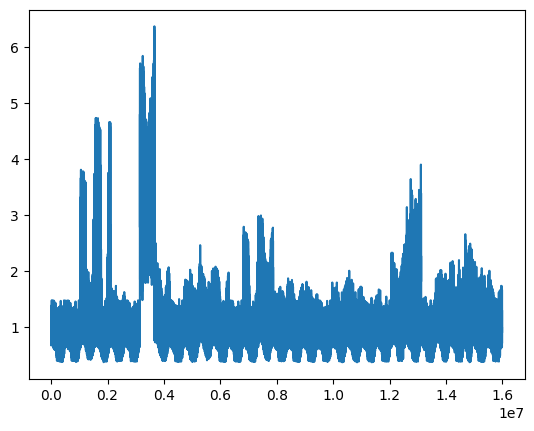

In [16]:
Overloads_df.max_depth.plot()

In [17]:
Overloads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15984578 entries, 0 to 15984577
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   nb_total   float64       
 1   scenario   object        
 2   agent      object        
 3   datetimes  datetime64[ns]
 4   max_depth  float16       
dtypes: datetime64[ns](1), float16(1), float64(1), object(2)
memory usage: 518.3+ MB


In [18]:
Overloads_df.max_depth=Overloads_df.max_depth.astype("float32") #because sort values does not deal with float16


In [19]:
best_df=Overloads_df.sort_values(['nb_total','max_depth'], ascending=True).drop_duplicates(['scenario','datetimes'])
#ascending=[True, False]
df_analysis_light=df_analysis.loc[best_df.index,:]
df_analysis_light["agent"]="best_agent"

#df_analysis_light=df_analysis_light.append(df_analysis[df_analysis.agent=="do_nothing"]).reset_index(drop=True)
df_analysis_light=pd.concat([df_analysis_light,df_analysis[df_analysis.agent=="do_nothing"]],ignore_index=True)
df_analysis_light=df_analysis_light.sort_values(['agent','scenario','datetimes'], ascending=True,ignore_index=True)
    
df_analysis_light_file_path=os.path.join(env_output_folder,'FlowDataset_light.file')
df_analysis_light.to_feather(df_analysis_light_file_path)

#### check that scenarios are continuous in the indices of the resultating dataframe. Otherwise reorder
This is needed for the get_overload_info_df method to run properly

In [20]:

Overloads=(df_analysis_light[lines_name]>= thermal_limits).astype('bool')
Overloads['scenario']=df_analysis_light['scenario']

Overloads_best_agent=Overloads[df_analysis_light.agent=="best_agent"]
Overloads_best_agent.head()


def first(df):
    return df.index[0]

def last(df):
    return df.index[-1]

firstLastIndices=pd.concat([Overloads_best_agent.groupby('scenario').apply(first),Overloads_best_agent.groupby('scenario').apply(last)],axis=1)
firstLastIndices

/tmp/ipykernel_109888/1142041764.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



0       1
scenario                    
2035-01-01_0       0    2017
2035-01-01_1    2018    4035
2035-01-01_2    4036    6053
2035-01-01_3    6054    8071
2035-01-01_4    8072   10089
2035-01-08_0   10090   12107
2035-01-08_1   12108   14125
2035-01-08_2   14126   16143
2035-01-08_3   16144   18161
2035-01-08_4   18162   20179
2035-01-15_0   20180   22197
2035-01-15_1   22198   24215
2035-01-15_2   24216   26233
2035-01-15_3   26234   28251
2035-01-15_4   28252   30269
2035-01-22_0   30270   32287
2035-01-22_1   32288   34305
2035-01-22_2   34306   36323
2035-01-22_3   36324   38341
2035-01-22_4   38342   40359
2035-01-29_0   40360   42377
2035-01-29_1   42378   44395
2035-01-29_2   44396   46413
2035-01-29_3   46414   48431
2035-01-29_4   48432   50449
2035-02-05_0   50450   52467
2035-02-05_1   52468   54485
2035-02-05_2   54486   56503
2035-02-05_3   56504   58521
2035-02-05_4   58522   60539
2035-02-12_0   60540   62557
2035-02-12_1   62558   64575
2035-02-12_2   64576   66593
2035-02-12_3   66594   68611
2035-02-12_4   68612   70629
2035-02-19_0   70630   72647
2035-02-19_1   72648   74665
2035-02-19_2   74666   76683
2035-02-19_3   76684   78701
2035-02-19_4   78702   80719
2035-02-26_0   80720   82737
2035-02-26_1   82738   84755
2035-02-26_2   84756   86773
2035-02-26_3   86774   88791
2035-02-26_4   88792   90809
2035-03-05_0   90810   92827
2035-03-05_1   92828   94845
2035-03-05_2   94846   96863
2035-03-05_3   96864   98881
2035-03-05_4   98882  100899
2035-03-12_0  100900  102917
2035-03-12_1  102918  104935
2035-03-12_2  104936  106953
2035-03-12_3  106954  108971
2035-03-12_4  108972  110989
2035-03-19_0  110990  113007
2035-03-19_1  113008  115025
2035-03-19_2  115026  117043
2035-03-19_3  117044  119061
2035-03-19_4  119062  121079
2035-03-26_0  121080  123097
2035-03-26_1  123098  125115
2035-03-26_2  125116  127133
2035-03-26_3  127134  129151
2035-03-26_4  129152  131169
2035-04-02_0  131170  133187
2035-04-02_1  133188  135205
2035-04-02_2  135206  137223
2035-04-02_3  137224  139241
2035-04-02_4  139242  141259
2035-04-09_0  141260  143277
2035-04-09_1  143278  145295
2035-04-09_2  145296  147313
2035-04-09_3  147314  149331
2035-04-09_4  149332  151349
2035-04-16_0  151350  153367
2035-04-16_1  153368  155385
2035-04-16_2  155386  157403
2035-04-16_3  157404  159421
2035-04-16_4  159422  161439
2035-04-23_0  161440  163457
2035-04-23_1  163458  165475
2035-04-23_2  165476  167493
2035-04-23_3  167494  169511
2035-04-23_4  169512  171529
2035-04-30_0  171530  173547
2035-04-30_1  173548  175565
2035-04-30_2  175566  177583
2035-04-30_3  177584  179601
2035-04-30_4  179602  181619
2035-05-07_0  181620  183637
2035-05-07_1  183638  185655
2035-05-07_2  185656  187673
2035-05-07_3  187674  189691
2035-05-07_4  189692  191709
2035-05-14_0  191710  193727
2035-05-14_1  193728  195745
2035-05-14_2  195746  197763
2035-05-14_3  197764  199781
2035-05-14_4  199782  201799
2035-05-21_0  201800  203817
2035-05-21_1  203818  205835
2035-05-21_2  205836  207853
2035-05-21_3  207854  209871
2035-05-21_4  209872  211889
2035-05-28_0  211890  213907
2035-05-28_1  213908  215925
2035-05-28_2  215926  217943
2035-05-28_3  217944  219961
2035-05-28_4  219962  221979
2035-06-04_0  221980  223997
2035-06-04_1  223998  226015
2035-06-04_2  226016  228033
2035-06-04_3  228034  230051
2035-06-04_4  230052  232069
2035-06-11_0  232070  234087
2035-06-11_1  234088  236105
2035-06-11_2  236106  238123
2035-06-11_3  238124  240141
2035-06-11_4  240142  242159
2035-06-18_0  242160  244177
2035-06-18_1  244178  246195
2035-06-18_2  246196  248213
2035-06-18_3  248214  250231
2035-06-18_4  250232  252249
2035-06-25_0  252250  254267
2035-06-25_1  254268  256285
2035-06-25_2  256286  258303
2035-06-25_3  258304  260321
2035-06-25_4  260322  262339
2035-07-02_0  262340  264357
2035-07-02_1  264358  266375
2035-07-02_2  266376  268393
2035-07-02_3  268394  270411
2035-07-02_4  270412  272429
2035-07-09_0  272430  274447
2035-07-09_1  274

### Build specific dataframe on overloads based on flow results with best agent

In [21]:
overload_best_agent_file_path=os.path.join(env_output_folder,'Overloads_info_Best_Agent.file')

if(os.path.isfile(overload_best_agent_file_path)):
    print("loading the file from: "+overload_best_agent_file_path)
    overloads_info_best_agent=pd.read_feather(overload_file_path)
    if only_do_nothing_agent:
        overloads_info_best_agent=overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"].reset_index(drop=True)

else:
    overloads_info_best_agent=get_overload_info_df(df_analysis_light,lines_name,thermal_limits,indicesLineOverloaded, verbose=True)
    print("saving file in: "+overload_best_agent_file_path)
    overloads_info_best_agent.to_feather(overload_best_agent_file_path)

overloads_info_best_agent.head(10)

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/marotant/dev/l2rpn_idf_2023/set_thermal_limit/utils/Create_Run_Dataframe.py:305: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

overload created
best_agent
do_nothing
Dataframe generated!!
Time taken = 1.5648164749145508 seconds
saving file in: Outputs/l2rpn_idf_2023_v7_x30/Overloads_info_Best_Agent.file


scenarios       agent  start_indices  end_indices  duration   
0  2035-02-12_4  best_agent            541          544         3  \
1  2035-01-01_0  best_agent            715          718         3   
2  2035-01-01_1  best_agent           1376         1379         3   
3  2035-01-01_1  best_agent           1380         1387         7   
4  2035-01-01_2  best_agent            414          415         1   
5  2035-01-08_0  best_agent           1568         1570         2   
6  2035-01-08_0  best_agent           1571         1572         1   
7  2035-01-08_0  best_agent           1589         1592         3   
8  2035-01-08_0  best_agent           1593         1594         1   
9  2035-01-08_0  best_agent           1595         1603         8   

   maxDepth_indices  maxDepths  hour_of_day  day_of_week  month  day_of_year   
0               541   1.030273           21            1      2           44  \
1               717   1.009766           11            2      1            3   
2              1378   1.040039           18            4      1            5   
3              1382   1.080078           19            4      1            5   
4               414   1.000000           10            1      1            2   
5              1569   1.019531           10            5      1           13   
6              1571   1.030273           10            5      1           13   
7              1591   1.080078           12            5      1           13   
8              1593   1.099609           12            5      1           13   
9              1599   1.110352           13            5      1           13   

            datetimes overload_line_name  
0 2035-02-13 21:00:00           75_76_11  
1 2035-01-03 11:40:00           68_76_12  
2 2035-01-05 18:45:00           68_76_12  
3 2035-01-05 19:05:00           68_76_12  
4 2035-01-02 10:25:00           68_76_12  
5 2035-01-13 10:40:00           68_76_12  
6 2035-01-13 10:50:00           68_76_12  
7 2035-01-13 12:30:00           68_76_12  
8 2035-01-13 12:40:00           68_76_12  
9 2035-01-13 13:10:00           68_76_12

In [22]:
overloads_info_best_agent.agent.unique()

array(['best_agent', 'do_nothing'], dtype=object)

Check that "best_agent" reduces the number of overload and their max depth

Text(0.5, 1.0, 'with do nothing agent')

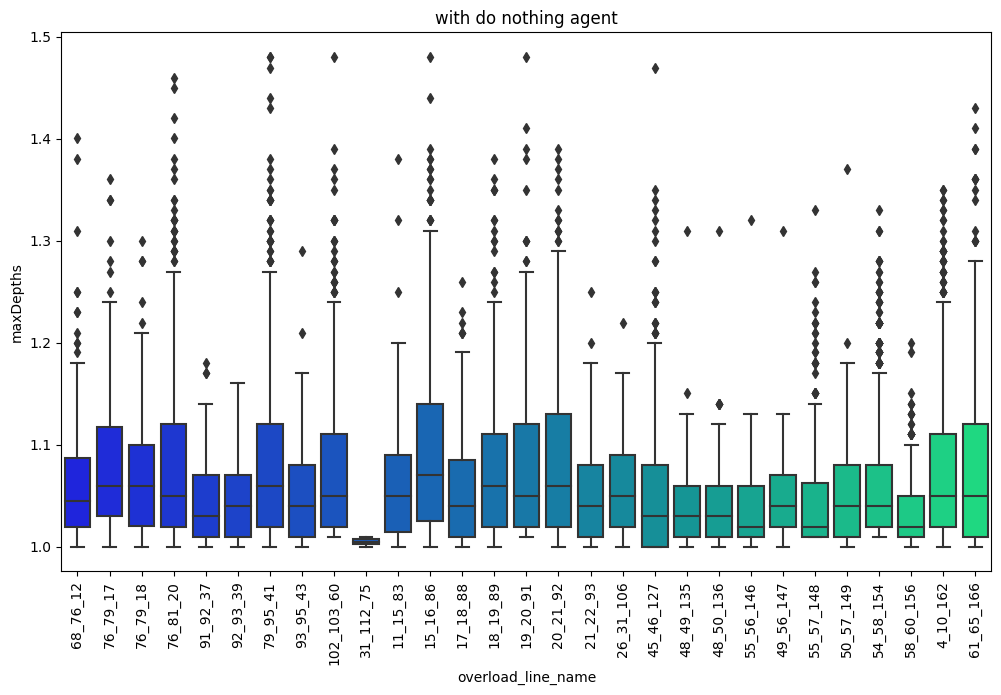

In [23]:
matplt.figure(figsize=(12, 7))
matplt.xticks(rotation=90)
sns.boxplot(x='overload_line_name', y='maxDepths', data=overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"], 
            palette='winter').set_title("with do nothing agent")

In [24]:
overloads_info_best_agent.agent.unique()

array(['best_agent', 'do_nothing'], dtype=object)

In [32]:
overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"].sort_values(["scenarios","start_indices"]).head()

scenarios       agent  start_indices  end_indices  duration   
16789  2035-01-01_0  do_nothing              1           13        12  \
12334  2035-01-01_0  do_nothing              4           13         9   
13005  2035-01-01_0  do_nothing              7           11         4   
16790  2035-01-01_0  do_nothing             78           95        17   
12335  2035-01-01_0  do_nothing             81           90         9   

       maxDepth_indices  maxDepths  hour_of_day  day_of_week  month   
16789                 6   1.150391            0            0      1  \
12334                 9   1.190430            0            0      1   
13005                 9   1.040039            0            0      1   
16790                84   1.179688            6            0      1   
12335                84   1.219727            6            0      1   

       day_of_year           datetimes overload_line_name  
16789            1 2035-01-01 00:25:00           4_10_162  
12334            1 2035-01-01 00:40:00           20_21_92  
13005            1 2035-01-01 00:40:00           21_22_93  
16790            1 2035-01-01 06:55:00           4_10_162  
12335            1 2035-01-01 06:55:00           20_21_92

In [33]:
overloads_info_best_agent[overloads_info_best_agent.agent=="best_agent"].sort_values(["scenarios","start_indices"]).head()

scenarios       agent  start_indices  end_indices  duration   
5652  2035-01-01_0  best_agent              1           12        11  \
4355  2035-01-01_0  best_agent              7           11         4   
4356  2035-01-01_0  best_agent             12           13         1   
5653  2035-01-01_0  best_agent             79           94        15   
4357  2035-01-01_0  best_agent             83           87         4   

      maxDepth_indices  maxDepths  hour_of_day  day_of_week  month   
5652                 4   1.150391            0            0      1  \
4355                 7   1.110352            0            0      1   
4356                12   1.000000            0            0      1   
5653                84   1.179688            6            0      1   
4357                84   1.110352            6            0      1   

      day_of_year           datetimes overload_line_name  
5652            1 2035-01-01 00:15:00           4_10_162  
4355            1 2035-01-01 00:30:00           20_21_92  
4356            1 2035-01-01 00:55:00           20_21_92  
5653            1 2035-01-01 06:55:00           4_10_162  
4357            1 2035-01-01 06:55:00           20_21_92

Text(0.5, 1.0, 'with best agent')

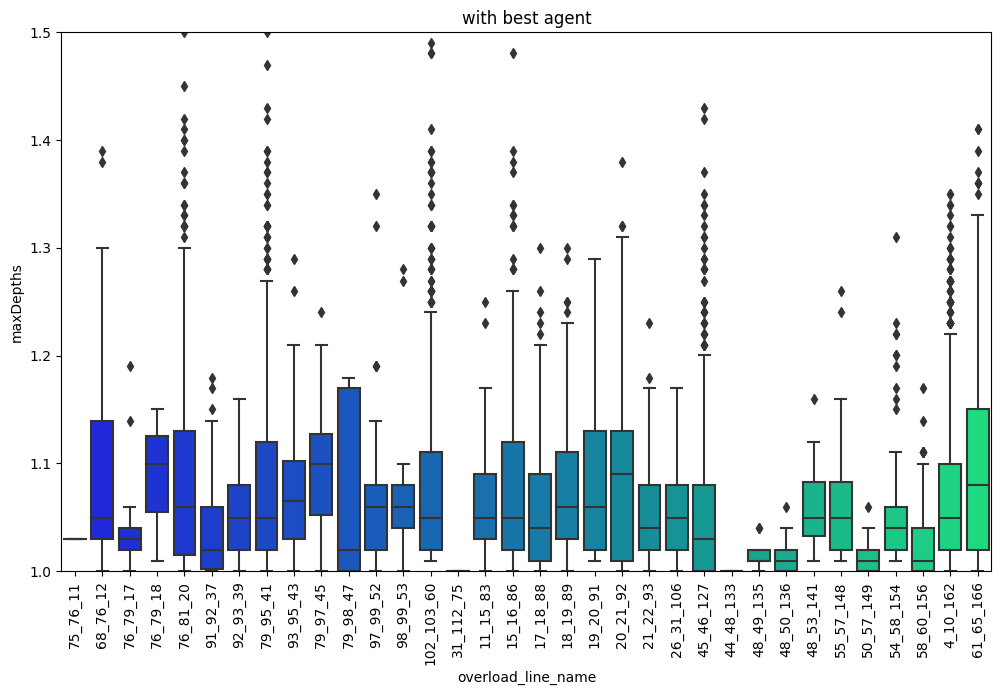

In [27]:
matplt.figure(figsize=(12, 7))
matplt.xticks(rotation=90)

matplt.ylim(1, 1.5)
sns.boxplot(x='overload_line_name', y='maxDepths', data=overloads_info_best_agent[overloads_info_best_agent.agent=="best_agent"], 
            palette='winter').set_title("with best agent")

check that there is no negative durations

<AxesSubplot: >

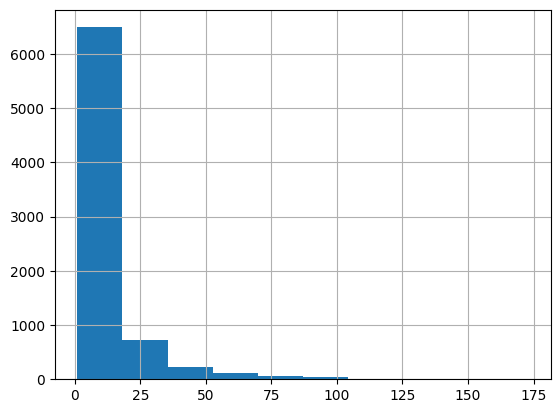

In [28]:
overloads_info_best_agent[overloads_info_best_agent.agent=="best_agent"].duration.hist()#.duration.hist()

<AxesSubplot: >

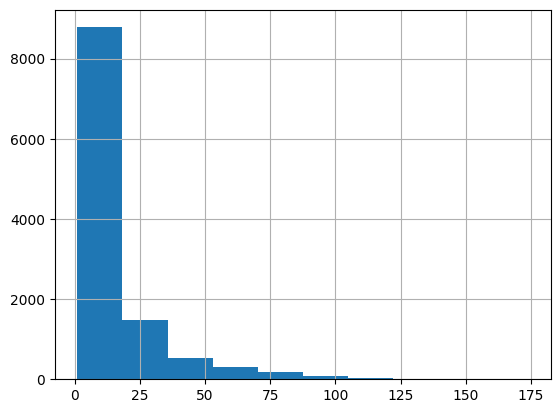

In [29]:
overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"].duration.hist()

In [30]:
percentage_reduced=np.round(1-(best_df["nb_total"].sum()/Overloads_df.loc[Overloads_df.agent=="do_nothing","nb_total"].sum()),2)*100
print("the percentage of overload decrease with considered actions is: "+str(percentage_reduced))

the percentage of overload decrease with considered actions is: 51.0


In [31]:
overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"]["overload_line_name"].unique()

array(['68_76_12', '76_79_17', '76_79_18', '76_81_20', '91_92_37',
       '92_93_39', '79_95_41', '93_95_43', '102_103_60', '31_112_75',
       '11_15_83', '15_16_86', '17_18_88', '18_19_89', '19_20_91',
       '20_21_92', '21_22_93', '26_31_106', '45_46_127', '48_49_135',
       '48_50_136', '55_56_146', '49_56_147', '55_57_148', '50_57_149',
       '54_58_154', '58_60_156', '4_10_162', '61_65_166'], dtype=object)